In [3]:
import csv
import pandas as pd
import networkx as nx
import random
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.vq import kmeans2, whiten
from sklearn.cluster import KMeans
import geopy
import zipcodes
from time import sleep
from geopy.extra.rate_limiter import RateLimiter
from mpl_toolkits.basemap import Basemap

ModuleNotFoundError: No module named 'mpl_toolkits.basemap'

In [ ]:
# plot pick-up data using k-means clustering
def plotKMeans(lat, long, k, iters):
    coordinates= np.array(list(zip(lat, long)))
    centroids, labels = kmeans2(whiten(coordinates), k, iter = iters)  
    plt.scatter(coordinates[:,0], coordinates[:,1], c=labels);
    plt.show()
    return centroids, labels

In [ ]:
def createDiGraphK(data, sample_size, k=20, iters=20, name='ktemp'):
    # cluster data using k-means
    lat = data['Lat']
    lon = data['Lon']
    coordinates= np.array(list(zip(lat, lon)))
    print(coordinates)
    centroids, labels = kmeans2(whiten(coordinates), k, iter = iters) 
    # create graph with k nodes
    G = nx.DiGraph(); 
    for pick_up in range(sample_size):
        
        # get k-means centroid from src and randomize dest based on uniform distribution among all clusters
        #rand_idx = random.randint(0, len(labels) - 1)
        rand_idx = pick_up
        la = lat[pick_up]
        lo = lon[pick_up]
        src = labels[rand_idx]
        dest = random.randint(0, k - 1)
        if (dest == src and src != 0):
            dest = 0

        # increase edge weight from src -->  dest by 1 
        if not G.has_node(src):
            G.add_node(src, lat=0, lon=0)
        if not G.has_node(dest):
            G.add_node(dest, lat=0, lon=0)
        if not G.has_edge(src, dest):
            G.add_edge(src, dest, weight=0)
        G[src][dest]['weight'] += 1
        G.node[src]['lat'] = (G.node[src]['lat'] +  la) / 2 #keep a running average
        G.node[src]['lon'] =  (G.node[src]['lon'] +  lo) / 2
        
        #print("Adding edge from " + str(src) + " to " + str(dest))
        if (pick_up > 1000 and pick_up % 1000 == 0):
            nx.write_graphml(G, "graphs/" + name + ".graphml")
    return G 

In [ ]:
# path to files
path_uber_raw = "uber-trip-data/uber-raw-data-apr14.csv"
data = pd.read_csv(path_uber_raw)
data

In [ ]:
# plot pick-up data using k-means clustering
def plotKMeans(lat, long, k, iters):
    coordinates= np.array(list(zip(lat, long)))
    centroids, labels = kmeans2(whiten(coordinates), k, iter = iters)  
    plt.scatter(coordinates[:,0], coordinates[:,1], c=labels);
    plt.show()
    return centroids, labels

In [ ]:
lat = data['Lat']
lon = data['Lon']
lat

In [ ]:
def draw_basemap(lat, lon, coords, shapefiles={}):
    m = Basemap(projection='merc',llcrnrlat=coords[0],urcrnrlat=coords[1],\
            llcrnrlon=coords[2], urcrnrlon=coords[3], resolution='h')
    m.drawcoastlines()
    m.drawstates()
    m.fillcontinents(color='coral',lake_color='aqua')
    for file, name in shapefiles.items():
        m.readshapefile(file, name)
    x,y = m(lon, lat)
    m.plot(x,y, 'bo', markersize=1)
    plt.show()
    
    return m

In [ ]:
c, l = plotKMeans(lat[1000:1100], lon[10000:10090], 20, 20)

In [12]:
# setup mercator basemap.
lat = data['Lat'].tolist()
lon = data['Lon'].tolist()
man_coords = [40.6664, 40.8851, -74.0587, -73.8890]
shapefiles ={}
shapefiles['shapes/ZIP_CODE_N'] = 'zipcodes'
m1=draw_basemap(lat[1:100], lon[1:100], man_coords, shapefiles) # plots raw points

NameError: name 'data' is not defined

In [ ]:

test_small = createDiGraphK(data, 2000, 2)

In [16]:
def get_pos(G, m):
    pos = {}
    #lat = {k:mean(v) for (k,v) in nx.get_node_attributes(test1, 'lat').items()}
    #lon = {k:mean(v) for (k,v) in nx.get_node_attributes(test1, 'lon').items()}
    lt = nx.get_node_attributes(G, 'lat')
    ln = nx.get_node_attributes(G, 'lon')
    for node_num in list(G.nodes()):
        pos[node_num] = m(ln[node_num], lt[node_num]) # KEEP IN MIND THIS IS NOW X,Y
    return pos

In [ ]:
def draw_graph(G, coords=[40.58, 40.88, -74.28, -73.840], shapefiles={}, node_size=50): 
    plt.figure(figsize=(18,12))
    m = Basemap(projection='merc',llcrnrlat=coords[0],urcrnrlat=coords[1],llcrnrlon=coords[2], urcrnrlon=coords[3], resolution='h')
    m.drawcoastlines()
    m.drawstates()
    m.fillcontinents(color='lightgreen',lake_color='aqua')
    #m = Basemap(projection='merc', width=10, height=10, lat_0=40.783058, lon_0=-73.971252)
    pos = get_pos(G, m)
    print("FINISHED PROJ. COORDINATES...STARTING NODES")
    nx.draw_networkx_nodes(G = G, pos = pos, node_color = 'b', alpha=0.8,node_size=node_size)
    nx.draw_networkx_edges(G = G, pos = pos, edge_color='white', alpha=0.8, arrows = True)
    for file, name in shapefiles.items():
        m.readshapefile(file, name)
    plt.show()
    return m

In [ ]:
shapefiles ={}
shapefiles['shapes/ZIP_CODE_N'] = 'zipcodes'
man_coords = [40.58, 40.88, -74.28, -73.840] #manhattan by default

In [ ]:
test_all = createDiGraphK(data, len(data), k=30, iters=30)

In [ ]:
draw_graph(test_all, man_coords, shapefiles)

In [ ]:
# scale graph 
node_lt = nx.get_node_attributes(test_all, 'lat').values()
node_ln = nx.get_node_attributes(test_all, 'lon').values()
pad = 0.01
c2 = [min(node_lt)-pad, max(node_lt)+pad, min(node_ln)-pad, max(node_ln)+pad]

In [ ]:
m3 = draw_graph(test_all, c2, shapefiles)

yay we got it visualized! now let's try to make the graph more meaningful by incorporating some of measures of centrality

In [ ]:
def get_stats(G):
    stats = {};  
    stats['out_degrees'] = G.out_degree(weight='weight'); 
    stats['closeness_centrality'] = nx.closeness_centrality(G); # hard to do the rest of these because of uniform dist. 
    stats['betweenness_centrality'] = nx.betweenness_centrality(G); 
    stats['eigenvalue_centrality'] = nx.eigenvector_centrality(G); 
    stats['pagerank'] = nx.pagerank(G); 
    return stats

In [ ]:
test_all.out_degree(weight='weight')

In [ ]:
# adjust sizing of nodes based on their relative out-degrees
og_size =  400
sizes = []
for node in list(test_all.nodes()):
    sizes.append(og_size*0.5*(out_weights[node])/2.0)
draw_graph(test_all, c2, shapefiles, node_size=sizes)

In [18]:
def get_weighted_nodes(G, og_size):
    # get weights into the range [0.5-1]
    out_raw = dict(G.out_degree(weight='weight'))
    min_out = min(out_raw.values())
    max_out = max(out_raw.values())
    out_weights = {k:(v-min_out)/(max_out-min_out) for (k,v) in out_raw.items()}
    
    # adjust sizing of nodes based on their relative out-degrees
    sizes = []
    for node in list(G.nodes()):
        sizes.append(og_size*0.5*(out_weights[node]) + 0.5*og_size)
    return sizes

Hmmm so there's BARELY any usage of the outer nodes. let's try to remove some outliers...and add a function to scale the map if necessary

In [ ]:
# remove outliers 
def removeOutliers(x, outlierConstant):
    a = np.array(x)
    upper_quartile = np.percentile(a, 75)
    lower_quartile = np.percentile(a, 25)
    IQR = (upper_quartile - lower_quartile) * outlierConstant
    quartileSet = (lower_quartile - IQR, upper_quartile + IQR)
    resultList = []
    for y in a.tolist():
        if y >= quartileSet[0] and y <= quartileSet[1]:
            resultList.append(y)
    return resultList

In [21]:
# return indices of valid points-- SHOULD USE THIS INSTEAD WHEN CONSIDERING TWO RELATED SETS OF POINTS!!!
def getOutliers(x, y, outlierConstant):
    a = np.array(x)
    b = np.array(y)
    upper_quartile_a = np.percentile(a, 75)
    lower_quartile_a = np.percentile(a, 25)
    upper_quartile_b = np.percentile(b, 75)
    lower_quartile_b = np.percentile(b, 25)
    IQR_a = (upper_quartile_a - lower_quartile_a) * outlierConstant
    IQR_b = (upper_quartile_b - lower_quartile_b) * outlierConstant
    quartileSet_a = (lower_quartile_a - IQR_a, upper_quartile_a + IQR_a)
    quartileSet_b = (lower_quartile_b - IQR_b, upper_quartile_b + IQR_b)
    valid = []
    for i,v in enumerate(a.tolist()):
        if (v >= quartileSet_a[0] and v <= quartileSet_a[1] and b[i] >= quartileSet_b[0] and b[i] <= quartileSet_b[1]):
            valid.append(i)
    return valid

In [20]:
def createDiGraphK_clean(data, sample_size, k=40, iters=20, name='ktemp'):
    # cluster data using k-means
    valid_idx = np.array(getOutliers(data['Lat'], data['Lon'], 1))
    lat = np.array(data['Lat'])[valid_idx]
    lon = np.array(data['Lon'])[valid_idx]
    coordinates= np.array(list(zip(lat, lon)))
    centroids, labels = kmeans2(whiten(coordinates), k, iter = iters) 
    num_points = len(lat)
    # create graph with k nodes
    G = nx.DiGraph(); 
    for pick_up in range(0,min(sample_size, num_points)):
        
        # get k-means centroid from src and randomize dest based on uniform distribution among all clusters
        rand_idx = random.randint(0, num_points - 1)
        la = lat[rand_idx]
        lo = lon[rand_idx]
        src = labels[rand_idx]
        dest = random.randint(0, k - 1)
        if (dest == src and src != 0):
            dest = 0

        # increase edge weight from src -->  dest by 1 
        if not G.has_node(src):
            G.add_node(src, lat=0, lon=0)
        if not G.has_node(dest):
            G.add_node(dest, lat=0, lon=0)
        if not G.has_edge(src, dest):
            G.add_edge(src, dest, weight=0)
        G[src][dest]['weight'] += 1
        
        G.node[src]['lat'] = (G.node[src]['lat'] +  la) / 2 #keep a running average
        G.node[src]['lon'] =  (G.node[src]['lon'] +  lo) / 2
        
        #print("Adding edge from " + str(src) + " to " + str(dest))
        if (pick_up > 1000 and pick_up % 1000 == 0):
            nx.write_graphml(G, "graphs/" + name + ".graphml")
    return G 

In [14]:
def get_coords(G, pad=0.01):
    # scale graph 
    node_lt = nx.get_node_attributes(G, 'lat').values()
    node_ln = nx.get_node_attributes(G, 'lon').values()
    node_lt = list(filter(lambda x: x != 0, node_lt)) # FILTER OUT ZEROS BC OF A BUG Idk
    node_ln = list(filter(lambda x: x != 0, node_ln))
    c2 = [min(node_lt)-pad, max(node_lt)+pad, min(node_ln)-pad, max(node_ln)+pad]
    print(c2)
    return c2

In [ ]:
def draw_graph_clean(G, coords=None, shapefiles={}, node_size=600): 
    plt.figure(figsize=(18,12))
    if coords is None:
        coords = get_coords(G)
    m = Basemap(projection='merc',llcrnrlat=coords[0],urcrnrlat=coords[1],llcrnrlon=coords[2], urcrnrlon=coords[3], resolution='h')
    m.drawcoastlines()
    m.drawstates()
    m.fillcontinents(color='blanchedalmond',lake_color='aqua')
    #m = Basemap(projection='merc', width=10, height=10, lat_0=40.783058, lon_0=-73.971252)
    pos = get_pos(G, m)
    print("FINISHED PROJ. COORDINATES...STARTING NODES")
    nx.draw_networkx_nodes(G = G, pos = pos, node_color = 'b', alpha=0.8,node_size=get_weighted_nodes(G, node_size))
    #nx.draw_networkx_edges(G = G, pos = pos, edge_color='white', alpha=0.8, arrows = True)
    for file, name in shapefiles.items():
        m.readshapefile(file, name)
    plt.show()
    return m

In [ ]:
g2 = createDiGraphK_clean(data, len(data), k=40, iters=40, name='k_all_uber')

In [ ]:
m2 = draw_graph_clean(g2, shapefiles=shapefiles)

ok lit. but what do these places actually mean? I wish we had more k-clusters...we could try finding the optimal k value that would minimize the "sum of squared distances"...but is that what we actually want? 

In [ ]:
m2 = draw_graph_clean(g2, shapefiles=shapefiles)

In [ ]:
# determine the optimal k-value 
def plot_k(data):
    K = range(20, 100, 5)
    inertia = []
    km = KMeans()
    for k in K:
        coordinates= np.array(list(zip(data['Lat'][1:10000], data['Lon'][1:10000])))
        km = KMeans(n_clusters=k)
        k_model = km.fit(coordinates)
        inertia.append(k_model.inertia_)
        
    plt.figure(figsize=(12,8))
    plt.plot(K, inertia, 'b.')
    plt.title("Inertia vs k")
    plt.xlabel("K")
    plt.ylabel("Inertia")
    plt.show()
    return inertia
    

In [ ]:
i = plot_k(data)

heyyyy so the "elbow" would be around 40-50, which is what we've been trying. nice

okay so trying to increase kvalues gives us more nodes to consider...but do we need that? idk, since there's no geographical relevance here so far. Also the edge weights rn are kinda visually meaningless so let's try to fix that -> maybe we can model CONGESTION by considering the amount of trips between each node

ok well we are actually still unsure of the relationship between the out/in-degree distributions, so the edges right now are not as relevant. maybe let's focus on analyzing solely the pickup locations for this dataset

In [10]:
# get  some colors
def draw_graph_clean_colors(G, coords=None, shapefiles={}, node_size=600): 
    plt.figure(figsize=(18,12))
    if coords is None:
        coords = get_coords(G)
    m = Basemap(projection='merc',llcrnrlat=coords[0],urcrnrlat=coords[1],llcrnrlon=coords[2], urcrnrlon=coords[3], resolution='h')
    m.drawcoastlines()
    m.drawstates()
    m.fillcontinents(color='blanchedalmond',lake_color='aqua')
    #m = Basemap(projection='merc', width=10, height=10, lat_0=40.783058, lon_0=-73.971252)
    pos = get_pos(G, m)
    
    # create networkx graph 
    print("FINISHED PROJ. COORDINATES...STARTING NODES")
    cmap = plt.cm.Blues
    nx.draw_networkx_nodes(G = G, pos = pos, node_color = get_weighted_nodes(G, 1.0), alpha=0.8,
                           node_size=get_weighted_nodes(G, node_size), cmap=cmap)
    #nx.draw_networkx_edges(G = G, pos = pos, edge_color='white', alpha=0.8, arrows = True)
    for file, name in shapefiles.items():
        m.readshapefile(file, name)
        
    # set colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=1))
    sm.set_array([])
    cbar = plt.colorbar(sm)
    
    plt.show()
    return m

In [ ]:
kgraph = nx.read_graphml('graphs/k_all_uber.graphml')
g4 = draw_graph_clean_colors(kgraph, shapefiles=shapefiles)

## now time for taxi dataset! 

jk let's verify our findings with a larger sample from the dataset. Before we only took April 2014 from the Uber set, but we have 6 juicy months worth of trip data from 2014 and another 6 months from 2015! 

In [20]:
months = ['apr', 'may', 'jun', 'jul', 'aug', 'sep']
data14 = pd.DataFrame()
for month in months: 
    path_uber_raw = "uber-trip-data/uber-raw-data-" + month + "14.csv"
    data_new = pd.read_csv(path_uber_raw)
    data14 = pd.concat([data14, data_new])

In [23]:
uber_apr_sep14 = createDiGraphK_clean(data14, len(data14), iters=40, name='uber_apr_sep14')

In [5]:
uber_apr_sep14 = nx.read_graphml('graphs/uber_apr_sep14.graphml')

[40.674626305512895, 40.80581848746916, -74.01999610177243, -73.93155986965338]
FINISHED PROJ. COORDINATES...STARTING NODES


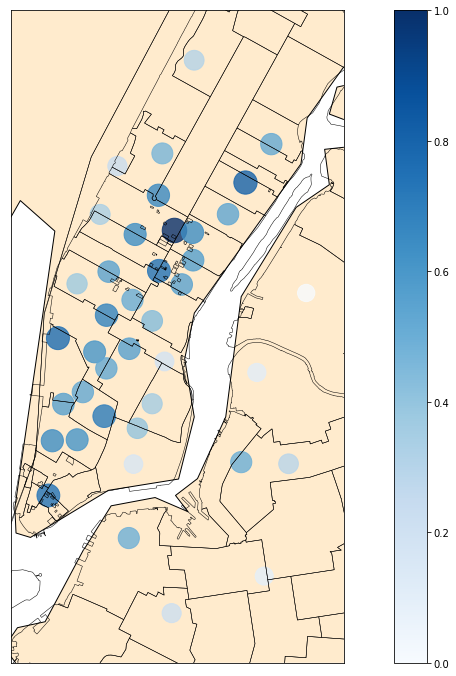

In [19]:
shapefiles ={}
shapefiles['shapes/ZIP_CODE_N'] = 'zipcodes'
g5 = draw_graph_clean_colors(uber_apr_sep14, shapefiles=shapefiles)

awesome so the clustering of the nodes look somewhat the same, just more dense. Let's double-check this with some graph analysis. 

In [30]:
out_u14 = list(dict(uber_apr_sep14.out_degree(weight='weight')).values())
out_u14 = [i/len(months) for i in out_u14]

In [4]:
uber_apr14 = nx.read_graphml('graphs/k_all_uber.graphml')
out_ua14 = list(dict(uber_apr14.out_degree(weight='weight')).values())

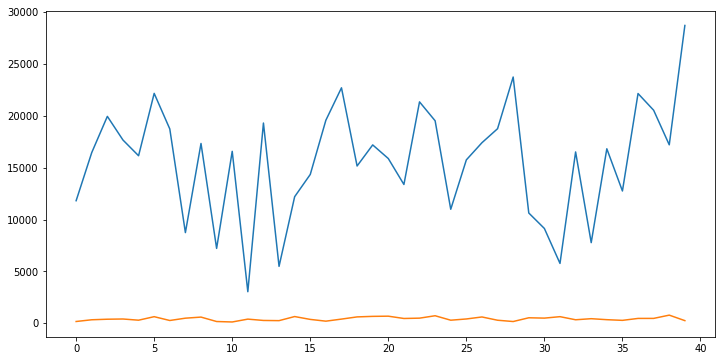

In [35]:
nodes = range(0,40)
plt.figure(figsize=(12,6))
plt.plot(nodes, out_u14, nodes, out_ua14)

Well this is weird - the average out-degree of the whole month is not similar to the out-degree of april? I think we need to compare them month by month...I will make a cleaner notebook for this. 

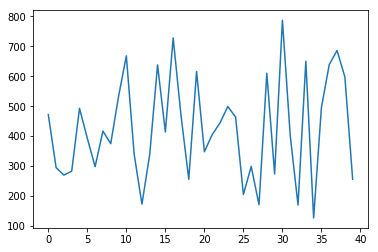

In [16]:
out14=dict(uber_apr14.out_degree(weight='weight'))
nodes = range(0,len(out14))
weights = [0]*len(out14)
weights = [out14[str(i)] for i in nodes]
plt.plot(nodes, weights)